In [1]:
#Import All Libraries
from IPython.display import Image
from os import listdir
import analysis as an
import numpy as np

#File Paths
cyclus_output = '../cyclus/US.sqlite'

In [2]:
# Run cyclus simulation
!rm ../cyclus/US.sqlite
!cyclus -i ../cyclus/input/US.xml -o ../cyclus/US.sqlite --warn-limit 0

rm: cannot remove '../cyclus/US.sqlite': No such file or directory
              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;   

In [3]:
# Import Cyclus Output File
cursor = an.get_cursor(cyclus_output)

# Get simulation start time, duration, and timestep
ini_yr, ini_month, dur, timestep = an.get_timesteps(cursor)

In [4]:
# Checks average nat_u output required
an.source_throughput(cursor, dur, 0.045, 0.002)

Throughput should be at least: 828815.840246 [kg]


828815.84024596168

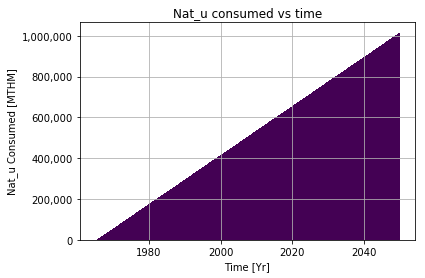

In [5]:
# Nat_u consumption vs Time
consumption = {'Nat_u_consumption': an.nat_u_timeseries(cursor)}
an.stacked_bar_chart(consumption, timestep,
                     'Time [Yr]', 'Nat_u Consumed [MTHM]',
                     'Nat_u consumed vs time',
                     'results/US/Nat_u consumption',
                     ini_yr)

Image(filename = 'results/US/Nat_u consumption.png')

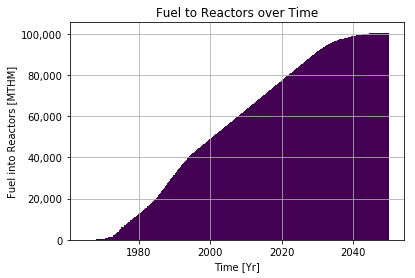

In [6]:
# Fuel into Reactors vs Time
to_reactor = {'Fuel_to_reactor': an.fuel_into_reactors(cursor)}
an.stacked_bar_chart(to_reactor, timestep,
                     'Time [Yr]', 'Fuel into Reactors [MTHM]',
                     'Fuel to Reactors over Time',
                     'results/US/Fuel to Reactors over Time', ini_yr)

Image(filename = 'results/US/Fuel to Reactors over Time.png')

/home/gyutae/cyclus/predicting-the-past/analysis/analysis.py:724: RuntimeWarning: invalid value encountered in true_divide
  u_util_timeseries = np.nan_to_num(fuel_timeseries / u_supply_timeseries)


The Average Fuel Utilization Factor is: 
0.0963157542591


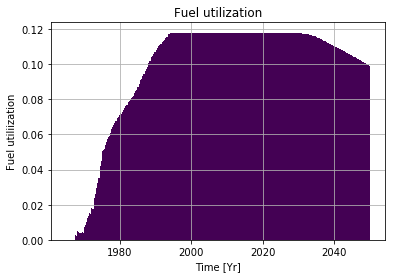

In [7]:
# Fuel utilization vs Time
fuel_util = {'Fuel Utilization Factor': an.u_util_calc(cursor)}
an.stacked_bar_chart(fuel_util, timestep,
                     'Time [Yr]', 'Fuel utiliization',
                     'Fuel utilization',
                     'results/US/Fuel utilization', ini_yr)

Image(filename = 'results/US/Fuel utilization.png')

FuelCycle has no values


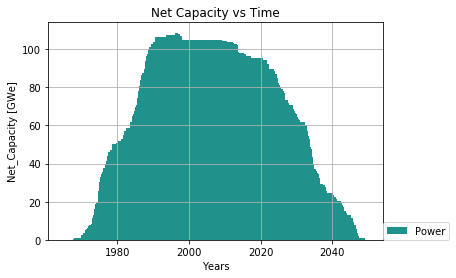

In [8]:
# Capacity vs Time
capacity_dict = an.get_power_dict(cursor)

an.stacked_bar_chart(capacity_dict, timestep,
                     'Years', 'Net_Capacity [GWe]',
                     'Net Capacity vs Time',
                     'results/US/Capacity vs Time', ini_yr)
  
Image(filename = 'results/US/Capacity vs Time.png')

FuelCycle has no values


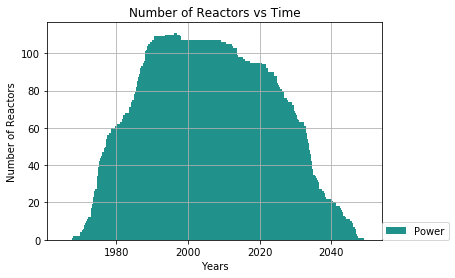

In [9]:
# Number of Reactors vs Time
an.stacked_bar_chart(an.get_deployment_dict(cursor), 
                     timestep, 'Years', 
                     'Number of Reactors',
                     'Number of Reactors vs Time',
                     'results/US/Number of Reactors vs Time', 
                     ini_yr)

Image(filename = 'results/US/Number of Reactors vs Time.png')

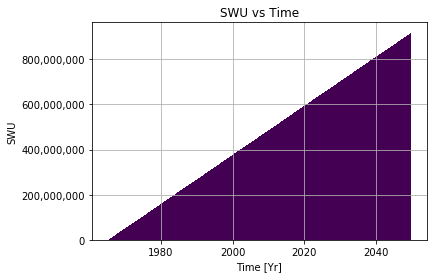

In [10]:
# SWU vs Time
an.stacked_bar_chart(an.get_swu_dict(cursor), 
                     timestep, 'Time [Yr]', 
                     'SWU', 'SWU vs Time',
                     'results/US/SWU vs Time', 
                     ini_yr)

Image(filename = 'results/US/SWU vs Time.png')

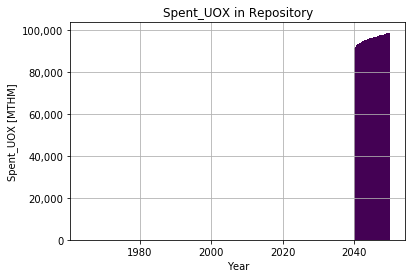

In [11]:
# HLW vs Time
sink_id = an.get_prototype_id(cursor, 'sink_hlw')
hlw = an.facility_commodity_flux(cursor, sink_id,
                                 ['casked_spent_uox'], False)
an.stacked_bar_chart(hlw, timestep,
                     'Year', 'Spent_UOX [MTHM]',
                     'Spent_UOX in Repository',
                     'results/US/Spent_UOX in Repository', 
                     ini_yr)

Image(filename = 'results/US/Spent_UOX in Repository.png')

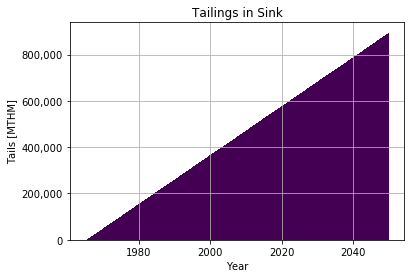

In [12]:
# Tails vs Time
sink_id = an.get_prototype_id(cursor, 'sink_llw')
tailings = an.facility_commodity_flux(cursor, sink_id,
                                      ['tails'], False)

an.stacked_bar_chart(tailings, timestep,
                     'Year', 'Tails [MTHM]',
                     'Tailings in Sink',
                     'results/US/Tailings in Sink', 
                     ini_yr)

Image(filename = 'results/US/Tailings in Sink.png')

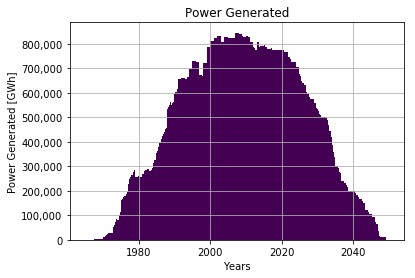

In [13]:
# Power Generation vs Time (1965 - 2050)
"""assumptions
- Refueling time: 1 month 
    avg refueling outage days from 1990~2016: 54.11 days
- Capacity factor:
    obtained from EIA for 1975~2016 and extrapolated until 
    2050 assuming constant capacity factor from 2016
    *https://www.statista.com/statistics/191201/capacity-factor-of-nuclear-power-plants-in-the-us-since-1975/
"""
hours_in_year = 24 * 365.25
cf_data = an.import_csv('published_data/US/capacity_factor_extrapolated.csv', ',')
cf = np.asarray(an.get_cf(cf_data))

capacity = capacity_dict['Power']
generated= {"US" : np.multiply(capacity, cf) * hours_in_year}
an.stacked_bar_chart(generated, timestep,
                     'Years', 'Power Generated [GWh]',
                     'Power Generated',
                     'results/US/Power Generated',
                     ini_yr)

Image(filename = 'results/US/Power Generated.png')

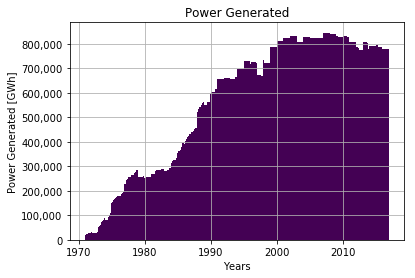

In [14]:
# Power Generation vs Time (1971 - 2016)
start_year = 1971
end_year = 2017
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year

timestep_range = timestep[start_index: end_index]
cf_range = cf[start_index : end_index]
generated_range  = {"US" : generated["US"][start_index : end_index]}

an.stacked_bar_chart(generated_range, timestep_range,
                     "Years", "Power Generated [GWh]",
                     "Power Generated",
                     "results/US/Power Generated 1971~2016",
                     1965)

Image(filename = 'results/US/Power Generated 1971~2016.png')

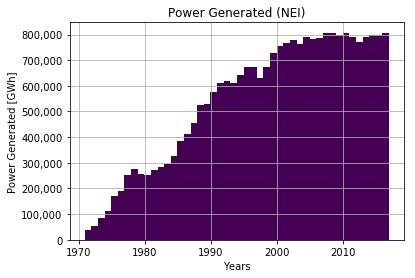

In [15]:
# Show Published Power Generated
generation_list = an.import_csv('published_data/US/generation.csv', ',')
generated_nei  = {"NEI" : an.get_generation(generation_list)}

an.stacked_bar_chart(generated_nei, timestep_range,
                     "Years", "Power Generated [GWh]",
                     "Power Generated (NEI)",
                     "published_data/US/Power Generated NEI",
                     1965)

Image(filename = 'published_data/US/Power Generated NEI.png')